In [29]:
%run supervised_functions.ipynb

# Generate data

In [ ]:
start_mols = pickle.load(open("datasets/my_uspto/unique_start_mols.pickle", 'rb'))

In [9]:
np.random.seed(42)

N = 100000
steps = 1

df_list = []
final_shape = 0
smiles_per_random_sample = 1000
pool_chunk_size = 10

# Create dataset for multi-step pred
with Pool(30) as p, tqdm.tqdm(total=N) as pbar:
    while final_shape < N:
        smiles = np.random.choice(start_mols, size=(smiles_per_random_sample,))

        for new_df in p.imap_unordered(functools.partial(generate_train_data, steps=steps), smiles, chunksize=10):
            df_list.append(new_df)
            final_shape += new_df.shape[0]
            
        pbar.update(final_shape - pbar.n)

main_df = pd.concat(df_list)
del df_list
print(main_df.shape)

# randomize
main_df = pd.concat([main_df[:int(main_df.shape[0]*0.8)].sample(frac=1), main_df[int(main_df.shape[0]*0.8):].sample(frac=1)])
print(main_df.shape)

100272it [03:55, 425.71it/s]                                                                         


(100272, 10)
(100272, 10)


# Neural Network!

In [10]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

Epoch 1, Loss: 23151.4941
Epoch 2, Loss: 13421.6543
Epoch 3, Loss: 5006.6743
Epoch 4, Loss: 1424.6224
Epoch 5, Loss: 517.5692
Epoch 6, Loss: 364.8164
Epoch 7, Loss: 346.8831
Epoch 8, Loss: 332.0376
Epoch 9, Loss: 334.5102
Epoch 10, Loss: 327.3152

FINAL TEST LOSS: 59.57931137084961


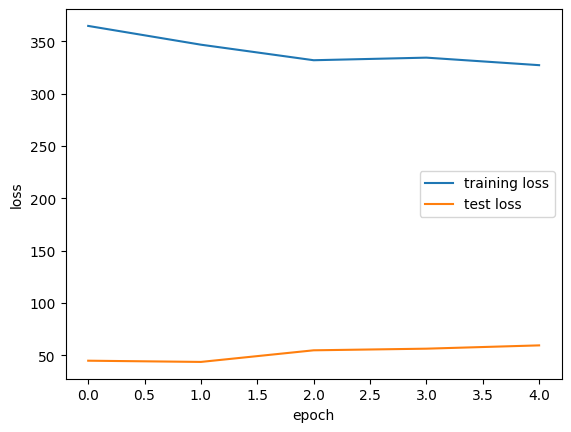

CPU times: user 7.42 s, sys: 897 ms, total: 8.32 s
Wall time: 4.18 s


NeuralNet(
  (fc1): Linear(in_features=20, out_features=20, bias=True)
  (bn1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (hidden_layers): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (last_layer): Linear(in_features=20, out_features=1, bias=True)
)

In [12]:
from sklearn.datasets import make_regression
x, y = make_regression(n_samples=5000, n_features=20, noise=2, random_state=42)
y = y.reshape(-1, 1)

batch_size = 64

%time train(x, y, num_hidden=2, hidden_size=20, lr=1e-2, epochs=10)

# Embedding type 2 - GIN training using attribute masking on clintox

In [13]:
model_name = "models/zinc2m_gin.pth"
gin_model = torch.load(model_name).to(device)

In [17]:
batch_size = 1024
X = []
for i in tqdm.tqdm(range(0, main_df.shape[0], batch_size)):
    reactants = main_df["reactant"][i:i+batch_size]
    products = main_df["product"][i:i+batch_size]
    X.append(torch.concatenate([get_mol_embedding(gin_model, reactants), get_mol_embedding(gin_model, products)], axis=1))
X = torch.concatenate(X, axis=0)
emb_len = X.shape[1]//2
X.shape

  2%|█▎                                                               | 2/98 [00:06<05:32,  3.46s/it]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Al`
  warnings.warn("Unknown value `%s`" % x)
  3%|█▉                                                               | 3/98 [00:10<05:17,  3.34s/it]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Pb`
  warnings.warn("Unknown value `%s`" % x)
 13%|████████▍                                                       | 13/98 [00:43<04:42,  3.32s/it]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ta`
  warnings.warn("Unknown value `%s`" % x)
 16%|██████████▍                                                     | 16/98 [00:54<04:56,  3.62s/it]/home/abhor/mi

torch.Size([100272, 256])

In [18]:
Y = []
for i in tqdm.tqdm(range(0, main_df.shape[0], batch_size)):
    Y.append(get_action_embedding(gin_model, main_df.iloc[i:i+batch_size][main_df.columns[1:-1]]))
Y = torch.concatenate(Y)
Y.shape

100%|████████████████████████████████████████████████████████████████| 98/98 [04:21<00:00,  2.67s/it]


torch.Size([100272, 256])

### MSE training

Epoch 1, Loss: 0.0618
Epoch 2, Loss: 0.0478
Epoch 3, Loss: 0.0399
Epoch 4, Loss: 0.0343
Epoch 5, Loss: 0.0303
Epoch 6, Loss: 0.0276
Epoch 7, Loss: 0.0257
Epoch 8, Loss: 0.0241
Epoch 9, Loss: 0.0228
Epoch 10, Loss: 0.0214
Epoch 11, Loss: 0.0202
Epoch 12, Loss: 0.0196
Epoch 13, Loss: 0.0189
Epoch 14, Loss: 0.0174
Epoch 15, Loss: 0.0168
Epoch 16, Loss: 0.0160
Epoch 17, Loss: 0.0154
Epoch 18, Loss: 0.0148
Epoch 19, Loss: 0.0144
Epoch 20, Loss: 0.0142
Epoch 21, Loss: 0.0141
Epoch 22, Loss: 0.0139
Epoch 23, Loss: 0.0134
Epoch 24, Loss: 0.0128
Epoch 25, Loss: 0.0125
Epoch 26, Loss: 0.0125
Epoch 27, Loss: 0.0121
Epoch 28, Loss: 0.0115
Epoch 29, Loss: 0.0111
Epoch 30, Loss: 0.0108
Epoch 31, Loss: 0.0106
Epoch 32, Loss: 0.0105
Epoch 33, Loss: 0.0104
Epoch 34, Loss: 0.0103
Epoch 35, Loss: 0.0100
Epoch 36, Loss: 0.0099
Epoch 37, Loss: 0.0098
Epoch 38, Loss: 0.0098
Epoch 39, Loss: 0.0097
Epoch 40, Loss: 0.0097
Epoch 41, Loss: 0.0096
Epoch 42, Loss: 0.0095
Epoch 43, Loss: 0.0091
Epoch 44, Loss: 0.00

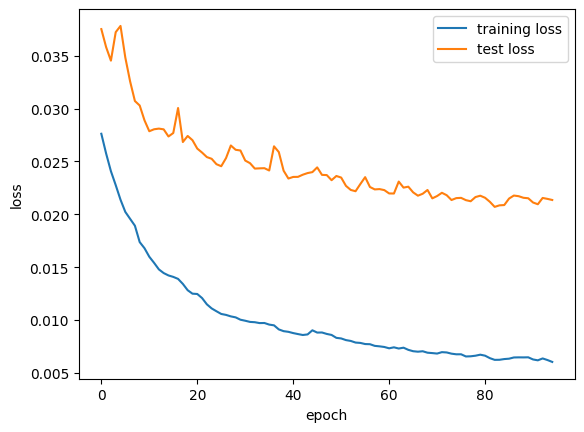

In [19]:
model = train(X, Y, hidden_size=500, num_hidden=3, lr=1e-3, epochs=100)

In [20]:
torch.save(model, "datasets/my_uspto/supervised_zinc_gin/mse_model.pth")

In [21]:
action_dataset = pd.read_csv("datasets/my_uspto/action_dataset-filtered.csv", index_col=0)
action_dataset = action_dataset.loc[action_dataset["action_tested"] & action_dataset["action_works"]]
action_dataset = action_dataset[["rsub", "rcen", "rsig", "rbond", "psub", "pcen", "psig", "pbond"]]
print(action_dataset.shape)

action_rsigs = data.Molecule.pack(list(map(molecule_from_smile, action_dataset["rsig"])))
action_psigs = data.Molecule.pack(list(map(molecule_from_smile, action_dataset["psig"])))

action_embeddings = get_action_dataset_embeddings(gin_model)
print(action_embeddings.shape)

(89384, 8)


/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ge`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `K`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ti`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Pt`
  warnings.warn("Unknown value `%s`" % x)
100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  7.42it/s]

torch.Size([89384, 256])


### Back to modeling

In [22]:
# I'm storing as lists, so doing numpy operations for the elements
correct_applicable_indices = []
correct_action_dataset_indices = []
action_embedding_indices = []

# for indices_used_for_data, correct_idx in tqdm.tqdm(map(get_emb_indices_and_correct_idx, main_df.iterrows()), total=main_df.shape[0]):
with Pool(20) as p:
    for indices_used_for_data, correct_app_idx, correct_act_idx in tqdm.tqdm(p.imap(get_emb_indices_and_correct_idx, main_df.iterrows(), chunksize=50), total=main_df.shape[0]):
        action_embedding_indices.append(indices_used_for_data)
        correct_applicable_indices.append(correct_app_idx)
        correct_action_dataset_indices.append(correct_act_idx)

100%|███████████████████████████████████████████████████████| 100272/100272 [03:32<00:00, 472.62it/s]


In [25]:
pred = model(torch.Tensor(X[int(main_df.shape[0]*0.8):]).to(device)).detach()
l = []
total = []
for i in tqdm.tqdm(range(pred.shape[0])):
    pred_for_i = pred[i]
    act_emb_for_i, correct_applicable_index = action_embeddings[action_embedding_indices[int(main_df.shape[0]*0.8)+i]], correct_applicable_indices[int(main_df.shape[0]*0.8)+i]

    rank, list_of_indices = get_ranking(pred_for_i, act_emb_for_i, correct_applicable_index, distance="euclidean")
    l.append(rank.item())
    total.append(act_emb_for_i.shape[0])
print(f"{np.mean(l)}({np.mean(total)}) +- {np.std(l)}  ")


100%|████████████████████████████████████████████████████████| 20055/20055 [00:08<00:00, 2383.05it/s]

12.260633258539018(413.8693093991523) +- 86.75253613900787  


In [45]:
train_idx = np.arange(0, int(X.shape[0]*0.8))
test_idx = np.arange(int(X.shape[0]*0.8), X.shape[0])

In [46]:
%%time
%matplotlib inline
train_reactants = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[train_idx]["reactant"]))).to(device)
train_products = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[train_idx]["product"]))).to(device)

test_reactants = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[test_idx]["reactant"]))).to(device)
test_products = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[test_idx]["product"]))).to(device)

/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Al`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Pb`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ta`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ru`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Na`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de

CPU times: user 8min, sys: 18.4 s, total: 8min 18s
Wall time: 8min 2s


In [ ]:
lr = 1e-3
epochs = 50
batch_size = 128


for distance_metric, negative_method, topk, emb_model_update in itertools.product(["euclidean"], ["all"], [10], [1]):
    print("@"*190)
    print("@"*190)
    print("@"*190)
    
    best_rank = 10000
    best_model = None
    
    model = PolicyNetwork().to(device)
    embedding_model = torch.load("models/zinc2m_gin.pth").to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  
    criterion = WeightedRegularizedTriplet()
    
    action_embeddings = get_action_dataset_embeddings(embedding_model)
    action_embeddings_norm = torch.linalg.norm(action_embeddings, axis=1)
    
    metric_dict = {"cos_rank_mean": [], "euc_rank_mean": [], "cos_rank_std": [], "euc_rank_std": [], 
                   "cos_rank_tot": [], "euc_rank_tot": [], "rmse": [], "cos_sim": [], "time(epoch_start-now)": []}
    # Train the model
    for epoch in range(1, epochs+1):
        start_time = time.time()
        model.train()
        for i in range(0, train_reactants.batch_size - batch_size, batch_size):
            # Forward pass
            outputs = model(train_reactants[i:i+batch_size], train_products[i:i+batch_size])

            # Calc negatives
            negatives = []
            
            for _i in range(outputs.shape[0]):
                curr_out = outputs[_i].detach()

                if negative_method == "applicable":
                    act_emb_for_i, correct_applicable_index = action_embeddings[action_embedding_indices[train_idx[i+_i]]], correct_applicable_indices[train_idx[i+_i]]
                    top = get_top_k_indices(curr_out, act_emb_for_i, correct_applicable_index, distance=distance_metric, k=50)
                    negatives.append(act_emb_for_i[top])
                
                elif negative_method == "all":
                    correct_action_dataset_index = correct_action_dataset_indices[train_idx[i+_i]]
                    if distance_metric == "euclidean":
                        dist = torch.linalg.norm(action_embeddings - curr_out, axis=1)
                    elif distance_metric == "cosine":
                        dist = (1 - action_embeddings.dot(curr_out)) / (action_embeddings_norm *torch.linalg.norm(curr_out))
                    sorted_idx = torch.argsort(dist)[:topk] # get topk
                    sorted_idx = sorted_idx[sorted_idx != correct_action_dataset_index] # Remove if correct index in list
                    negatives.append(action_embeddings[sorted_idx])
                        
            negatives = torch.Tensor(torch.concatenate(negatives, axis=0)).to(device)
                                
            # get targets
            targets = torch.Tensor(get_action_embedding(embedding_model, main_df.iloc[i:i+batch_size][main_df.columns[1:-1]])).to(device)
                                
            # Calc loss
            inputs = torch.concat([outputs, targets, negatives])
            labels = torch.concat([torch.arange(outputs.shape[0]), torch.arange(targets.shape[0]), torch.full((negatives.shape[0],), -1)]).to(device)
            loss = criterion(inputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print ('{:.6f}({})'.format(loss.item(), epoch), end='  ')
        
        # SWITCH INDENT HERE ----
        model.eval()
        with torch.no_grad():
            print()

            margin_string = f"# emb_model_update = {emb_model_update} | -ve_method = {negative_method} | dist_metric = {distance_metric} | topk = {topk} #"
            print("#" * len(margin_string))
            print(margin_string)
            print("#" * len(margin_string))

            # Predictions and action component-wise loss
            pred = model(test_reactants, test_products).detach()
            true = get_action_embedding(embedding_model, main_df.iloc[test_idx][main_df.columns[1:-1]])

            metric_df = pd.DataFrame(columns=["rmse", "cos_sim", "euc_rank_mean", "euc_rank_std", "euc_rank_tot", "cos_rank_mean", "cos_rank_std", "cos_rank_tot", "time(epoch_start-now)"])

            # Print Test metrics
            metric_dict["rmse"].append( (((pred-true)**2).sum(axis=1)**0.5).mean().item() )
            metric_dict["cos_sim"].append( ((pred*true).sum(axis=1) / torch.linalg.norm(pred, axis=1) / torch.linalg.norm(true, axis=1)).mean().item() )

            # Print Test metric - Rank
            for dist in ["euclidean", "cosine"]:
                rank_list = []
                l = []
                total = []
                for i in range(pred.shape[0]):
                    pred_for_i = pred[i]
                    act_emb_for_i, correct_applicable_index = action_embeddings[action_embedding_indices[test_idx[i]]], correct_applicable_indices[test_idx[i]]

                    rank, list_of_indices = get_ranking(pred_for_i, act_emb_for_i, correct_applicable_index, distance=dist)
                    l.append(rank.item())
                    total.append(act_emb_for_i.shape[0])
                rank_list.append(f"{np.mean(l):.4f}({np.mean(total)}) +- {np.std(l):.4f}")
                metric_dict[f"{dist[:3]}_rank_mean"].append(np.mean(l))
                metric_dict[f"{dist[:3]}_rank_std"].append(np.std(l))
                metric_dict[f"{dist[:3]}_rank_tot"].append(np.mean(total))

            metric_dict["time(epoch_start-now)"].append(f"{(time.time()-start_time)/60:.2f} min")
            for col in metric_df.columns:
                metric_df[col] = [metric_dict[col][-1]]
            metric_df.index = [epoch]
            print(tabulate(metric_df, headers='keys', tablefmt='fancy_grid'))
            print()
            
        # Update embedding model and action_embeddings
        if epoch % emb_model_update == 0:
            embedding_model.load_state_dict(model.GIN.state_dict())
            action_embeddings = get_action_dataset_embeddings(embedding_model)
            action_embeddings_norm = torch.linalg.norm(action_embeddings, axis=1)

        # Update best model
        if metric_dict["euc_rank_mean"][-1] < best_rank:
            best_rank = metric_dict["euc_rank_mean"][-1]
            best_model = type(model)()
            best_model.load_state_dict(model.state_dict())
            best_epoch = epoch
            print(f"BEST MODEL UPDATED! BEST RANK = {best_rank}")
            
    fig = plt.figure(figsize=(8, 8))
    for dist in filter(lambda x: "mean" in x, metric_dict.keys()):
        plt.plot(metric_dict[dist], label=dist)
    plt.title("Ranks")
    plt.xlabel("epoch")
    plt.ylabel("ranking")
    plt.legend()
    fig.show()
    
    # save everything
    folder = f"models/supervised/{steps}step/emb_model_update={emb_model_update}||-ve_method={negative_method}||dist_metric={distance_metric}||topk={topk}"
    os.makedirs(folder, exist_ok = True)
    torch.save(model, os.path.join(folder, "model.pth"))
    pd.DataFrame.from_dict(metric_dict).to_csv(os.path.join(folder, "metrics.csv"))
    fig.savefig(os.path.join(folder, "plot.png"))
    json.dump({
        "lr": lr,
        "epochs": epochs, 
        "batch_size": batch_size,
        "train_samples": train_idx.shape,
        "test_samples": test_idx.shape,
        "distance_metric": distance_metric,
        "negative_method": negative_method,
        "topk": topk,
        "emb_model_update": emb_model_update,
        "best_epoch": best_epoch,
        "best_rank": best_rank
    }, open(os.path.join(folder, "config.txt"), 'w'))

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  7.63it/s]
